**Initialization**

In [1]:
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'

import cv2
import numpy as np
import pandas as pd
import random
import pickle
from PIL import Image
from os.path import isfile
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

**Create model and load weights**

In [2]:

BOX_SIZE = 512

def preprocess_image(img):
    from keras.applications.densenet import preprocess_input
    return preprocess_input(img)


def get_branch_model(inp_shape):
    from keras.applications.densenet import DenseNet121
    model = DenseNet121(input_shape=inp_shape, include_top=False, weights=None, pooling='max')
    return model


def build_model(img_shape, activation='sigmoid'):
    from keras import backend as K
    from keras.optimizers import Adam
    from keras.engine.topology import Input
    from keras.layers import Concatenate, Conv2D, Dense, Flatten, Lambda, Reshape
    from keras.models import Model, load_model

    optim = Adam(lr=0.0001)
    branch_model = get_branch_model(img_shape)

    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:], name='hm_inp_a')
    xb_inp = Input(shape=branch_model.output_shape[1:], name='hm_inp_b')
    x1 = Lambda(lambda x: x[0] * x[1], name='lambda_1')([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1], name='lambda_2')([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]), name='lambda_3')([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x), name='lambda_4')(x3)
    x = Concatenate(name='concat_1')([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid', name='hm_conv_2d_1')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1), name='hm_reshape_2')(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid', name='hm_conv_2d_2')(x)
    x = Flatten(name='flatten')(x)

    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x, name='full_model')
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model


def get_trained_model():
    model, branch_model, head_model = build_model(img_shape=(BOX_SIZE, BOX_SIZE, 3))
    model.load_weights('../input/whales-2019-models/ft_v5_512px_finetune_0_final_v2_0.969993.model')
    return model, branch_model, head_model
    

**Load image routines and apply precomputed boxes**

In [3]:
def expand_path(p):
    if isfile('../input/humpback-whale-identification/train/' + p):
        return '../input/humpback-whale-identification/train/' + p
    if isfile('../input/humpback-whale-identification/test/' + p):
        return '../input/humpback-whale-identification/test/' + p
    return p


def get_boxes():
    temp_p2bb = pickle.load(open('../input/whales-2019-models/p2bb_averaged_v1.pkl', 'rb'))
    p2bb = {}
    for k in temp_p2bb:
        p2bb[k + '.jpg'] = temp_p2bb[k]
    return p2bb


def read_single_image(path):
    try:
        img = np.array(Image.open(path))
    except:
        try:
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        except:
            print('Fail')
            return None

    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    if img.shape[2] == 2:
        img = img[:, :, :1]

    if img.shape[2] == 1:
        img = np.concatenate((img, img, img), axis=2)

    if img.shape[2] > 3:
        img = img[:, :, :3]

    return img


def read_cropped_image(p, x0, y0, x1, y1, img_shape=(224, 224, 3)):
    anisotropy = 2.15
    crop_margin = 0.05

    # Read the image
    img = read_single_image(p)
    size_x, size_y = img.shape[1], img.shape[0]

    dx = x1 - x0
    dy = y1 - y0
    x0 -= dx * crop_margin
    x1 += dx * crop_margin + 1
    y0 -= dy * crop_margin
    y1 += dy * crop_margin + 1
    if x0 < 0: x0 = 0
    if x1 > size_x: x1 = size_x
    if y0 < 0: y0 = 0
    if y1 > size_y: y1 = size_y
    dx = x1 - x0
    dy = y1 - y0
    if dx > dy * anisotropy:
        dy = 0.5 * (dx / anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx = 0.5 * (dy * anisotropy - dx)
        x0 -= dx
        x1 += dx

    if x0 < 0: x0 = 0
    if x1 > size_x: x1 = size_x
    if y0 < 0: y0 = 0
    if y1 > size_y: y1 = size_y
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

    if y0 != y1 and x0 != x1:
        img = img[y0:y1, x0:x1, :]
    img = cv2.resize(img, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_LINEAR)
    if len(img.shape) == 2:
        img = np.concatenate((img, img, img), axis=2)

    return img


**Create activation maps**

It's main functions. We got tensor from last BatchNormalization layer (also we can use last activation layer). It has shape like (10, 16, 16, 1024) or (16, 16, 1024) for single image in batch. On the next GlobalMaxPooling layer it converted to vector with 1024 elements in it. To generate N-th element of vector maximum value is taken from (16 x 16) matrix. So pixel located in position with maximum value define the vector value. This vector next goes to head model, which compare whale parameters. So we need to find places on (16x16) matrix where maximum value appear often. Also it's interesting to find places where values change often from one feature map to next feature map. We can use value of standard deviation to mark such places. 

So colors on generated images:
* Pink - places where value of max appears often
* Green - places where Std is large
* White - Pink + Green

In [4]:
def normalize_array(arr):
    arr = 255.0 * (arr - arr.min()) / (arr.max() - arr.min())
    return arr


def create_activation_map_for_images(model, images, preproc_image):
    images_preproc = preproc_image(images.astype(np.float32))
    preds = model.predict(images_preproc)
    print('Shape of predictions: {}'.format(preds.shape))

    hmaps = []
    for z in range(images.shape[0]):
        img_orig = images[z]
        heatmap = preds[z]
    
        # Uncomment it to emulate RELU activation
        # heatmap[heatmap < 0] = 0.

        ch0 = np.zeros_like(heatmap[:, :, 0])
        ch1 = np.zeros_like(heatmap[:, :, 0])
        ch2 = np.zeros_like(heatmap[:, :, 0])

        # Find how often maximum is in each pixel.
        for k in range(heatmap.shape[2]):
            p = heatmap[:, :, k]
            mx = p.max()
            if mx == 0:
                continue
            for i in range(heatmap.shape[0]):
                for j in range(heatmap.shape[1]):
                    if p[i, j] == mx:
                        ch0[i, j] += 1
                        ch2[i, j] += 1

        for i in range(heatmap.shape[0]):
            for j in range(heatmap.shape[1]):
                mn = heatmap[i, j].min()
                mx = heatmap[i, j].max()
                mean = heatmap[i, j].mean()
                std = heatmap[i, j].std()
                # print(i, j, mn, mx, mean, std, mx - mn)
                ch1[i, j] = std

        ch0 = normalize_array(ch0)
        ch1 = normalize_array(ch1)
        ch2 = normalize_array(ch2)
        ch = np.stack((ch0, ch1, ch2), axis=2)

        ch = cv2.resize(ch.astype(np.uint8), (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_LANCZOS4)

        ch = normalize_array(ch)

        heat = (0.2 * img_orig + (0.1 * img_orig * ch) / 255 + 0.7 * ch).astype(np.uint8)
        heat = heat.astype(np.uint8)
        heat = normalize_array(heat)

        img_line = np.concatenate(
            (img_orig, ch, heat), axis=1
        )
        hmaps.append(img_line)

    return np.array(hmaps)


def create_activation_maps():
    from keras.models import Model
    model, branch_model, head_model = get_trained_model()

    bboxes = get_boxes()

    x = branch_model.layers[-3].output
    branch_model_modified = Model(inputs=branch_model.inputs, outputs=x)
    # print(branch_model_modified.summary())

    start = 10
    end = 50
    image_ids = pd.read_csv('../input/humpback-whale-identification/sample_submission.csv')['Image'].values[start:end]
    images = []
    for image_id in image_ids:
        f = expand_path(image_id)
        bb = bboxes[image_id]
        img_orig = read_cropped_image(f, bb[0], bb[1], bb[2], bb[3], img_shape=(BOX_SIZE, BOX_SIZE, 3))
        images.append(img_orig)

    img_line = create_activation_map_for_images(branch_model_modified, np.array(images), preprocess_image)

    for i, image_id in enumerate(image_ids):
        img = cv2.cvtColor(img_line[i].astype(np.uint8), cv2.COLOR_RGB2BGR)
        img_path = image_id
        cv2.imwrite(img_path, img)
        print('Heatmap for image: {}'.format(image_id))
        # Image(img_line[i].astype(np.uint8))
        display(Image(filename=img_path))

**Run script**

Using TensorFlow backend.


Shape of predictions: (40, 16, 16, 1024)
Heatmap for image: 00313e2d2.jpg


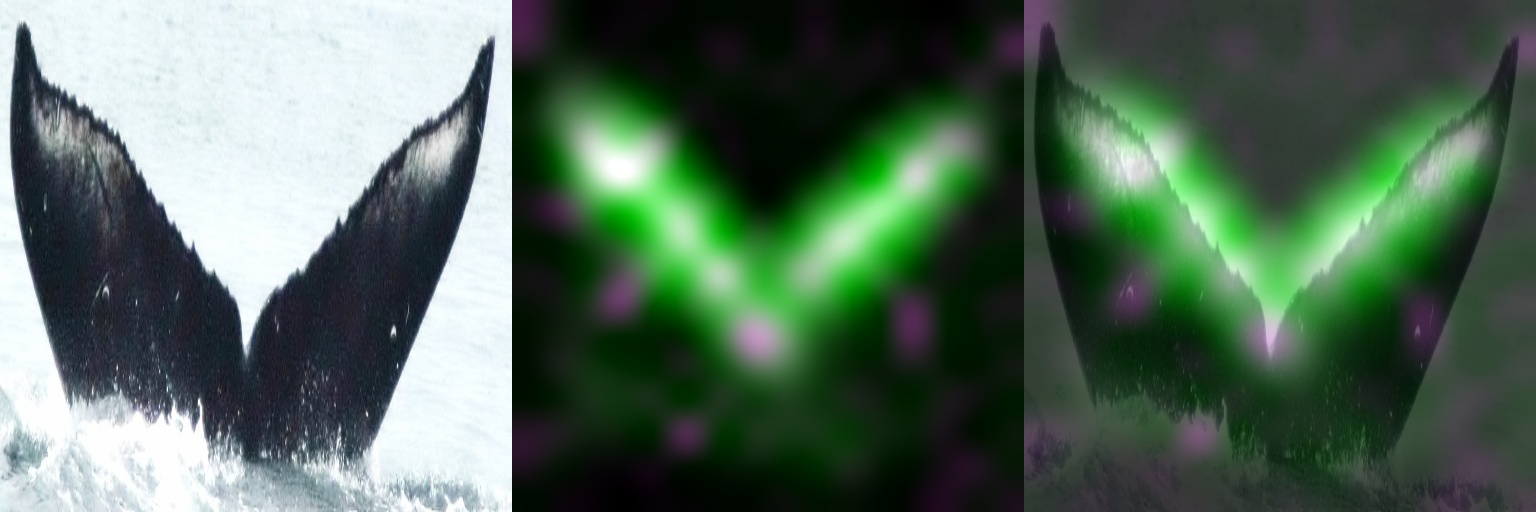

Heatmap for image: 00379666f.jpg


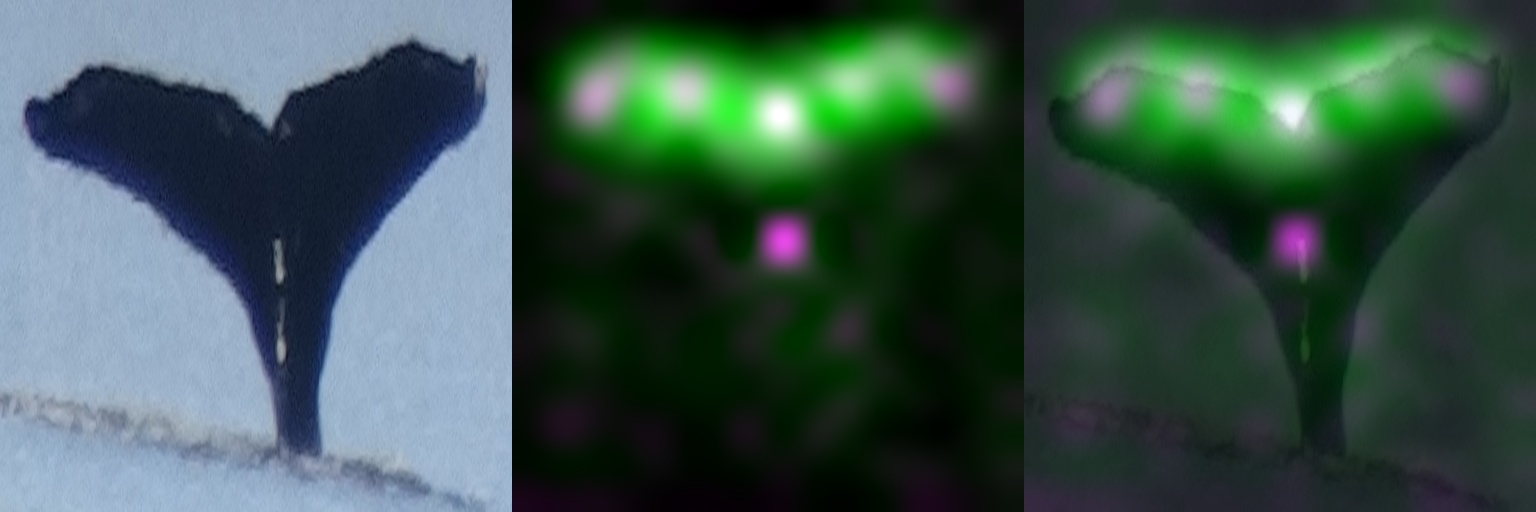

Heatmap for image: 0041a9867.jpg


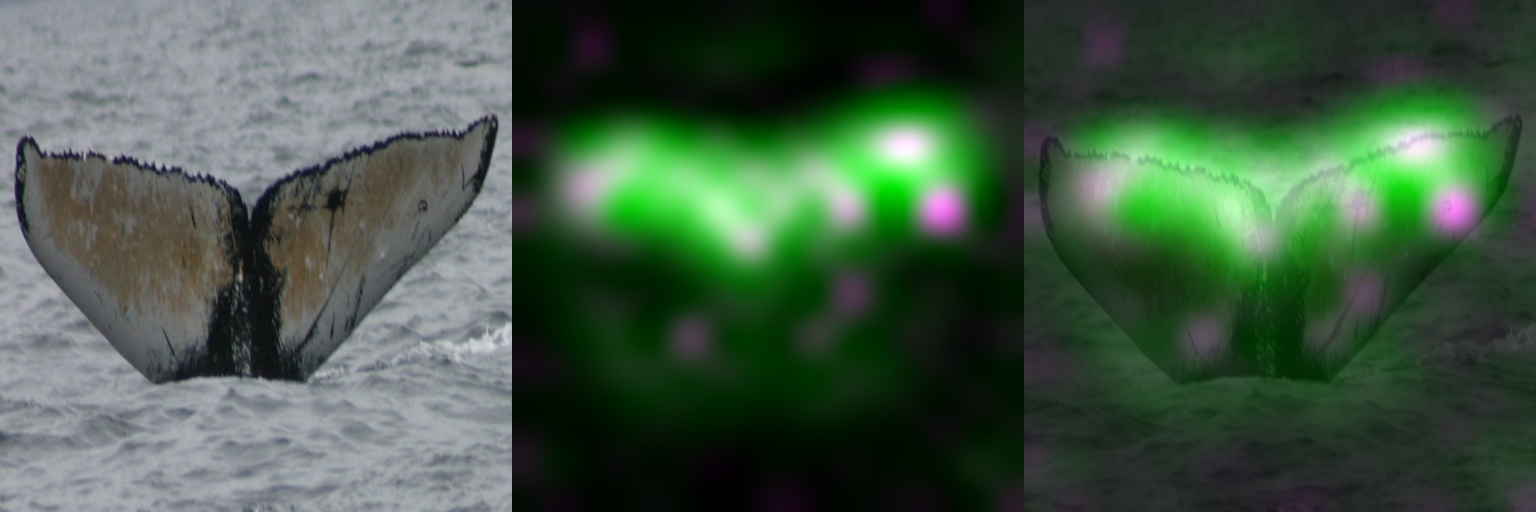

Heatmap for image: 004344e9f.jpg


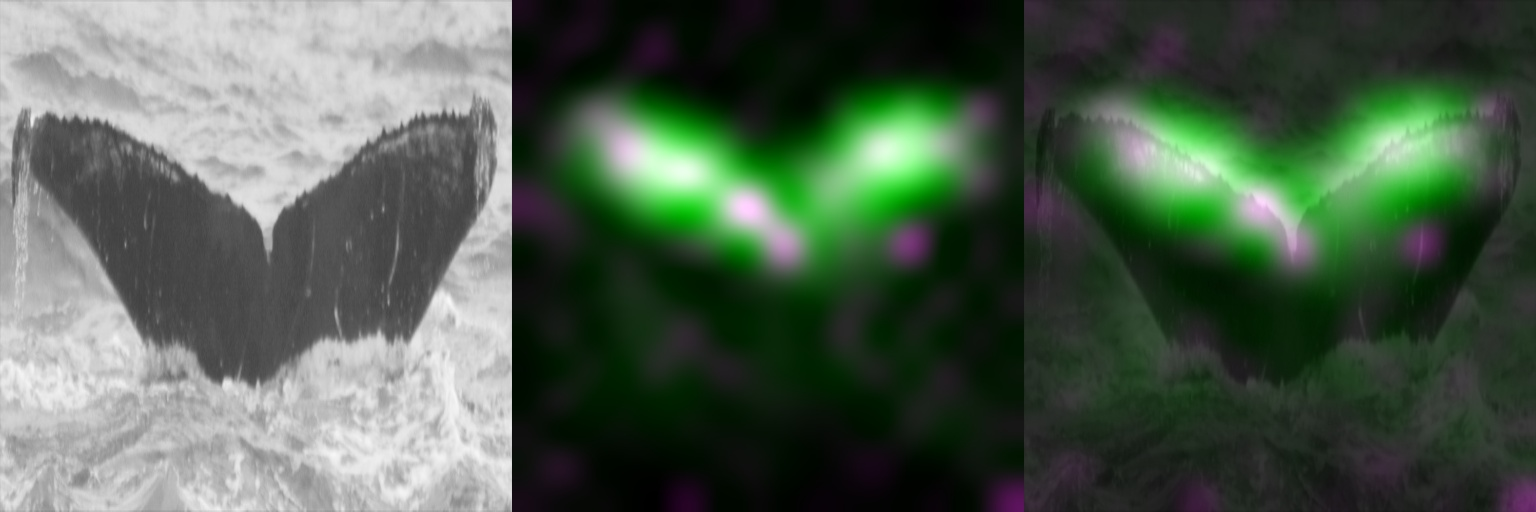

Heatmap for image: 0048970f9.jpg


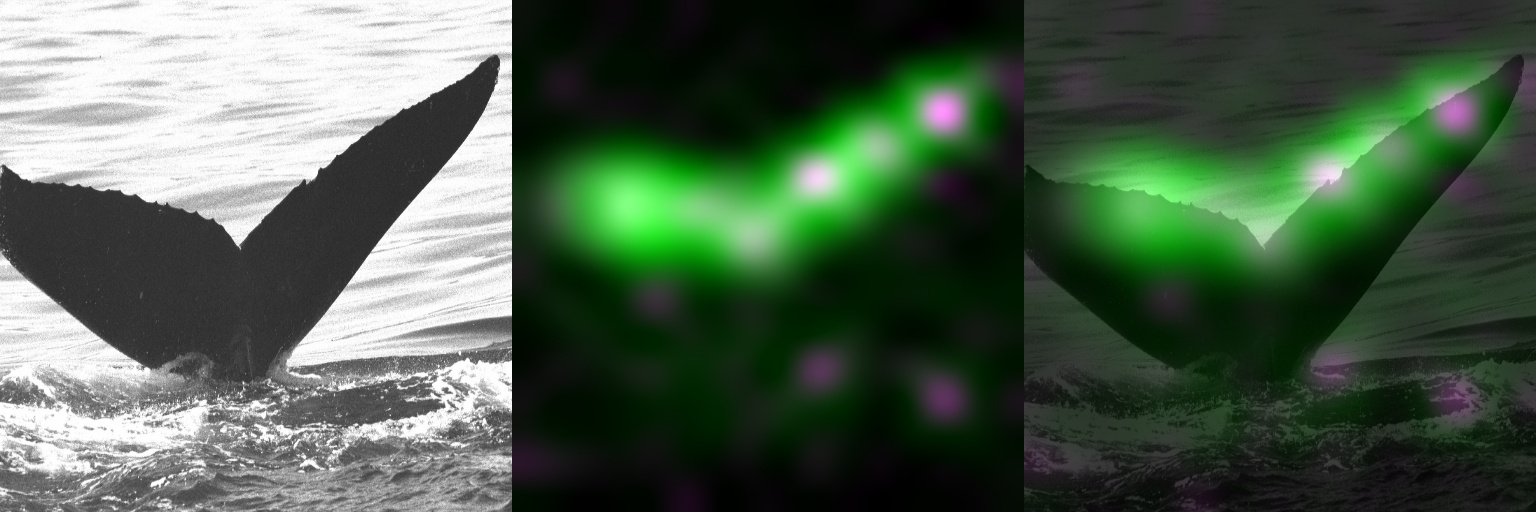

Heatmap for image: 004fa8ff7.jpg


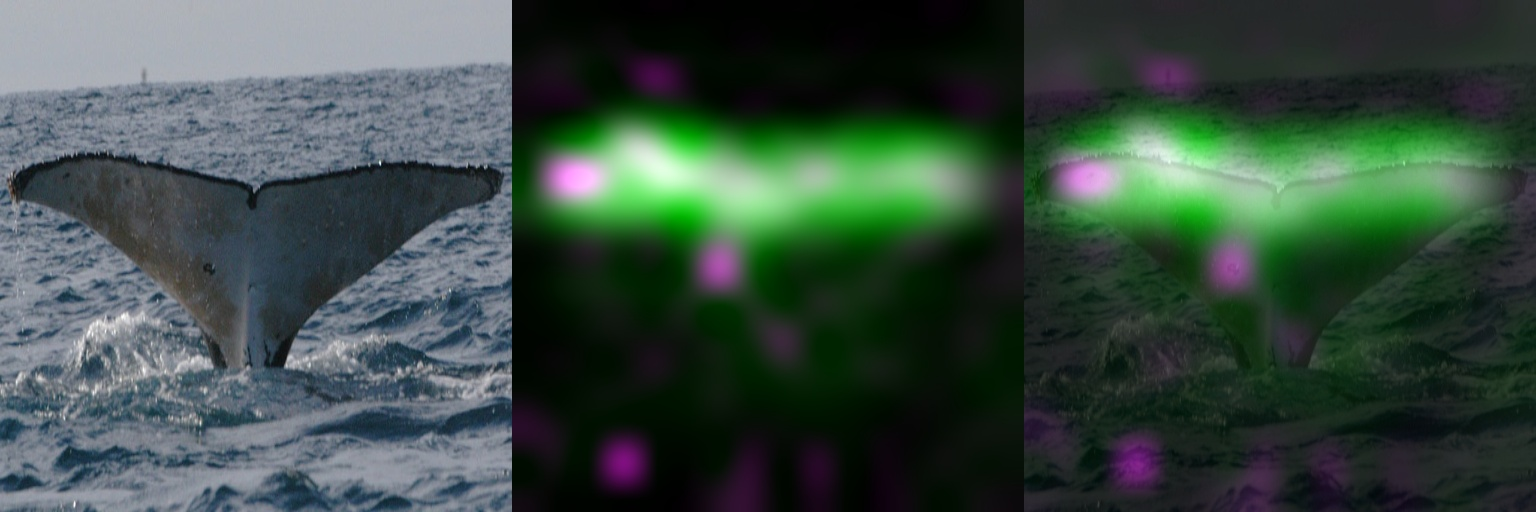

Heatmap for image: 00512687e.jpg


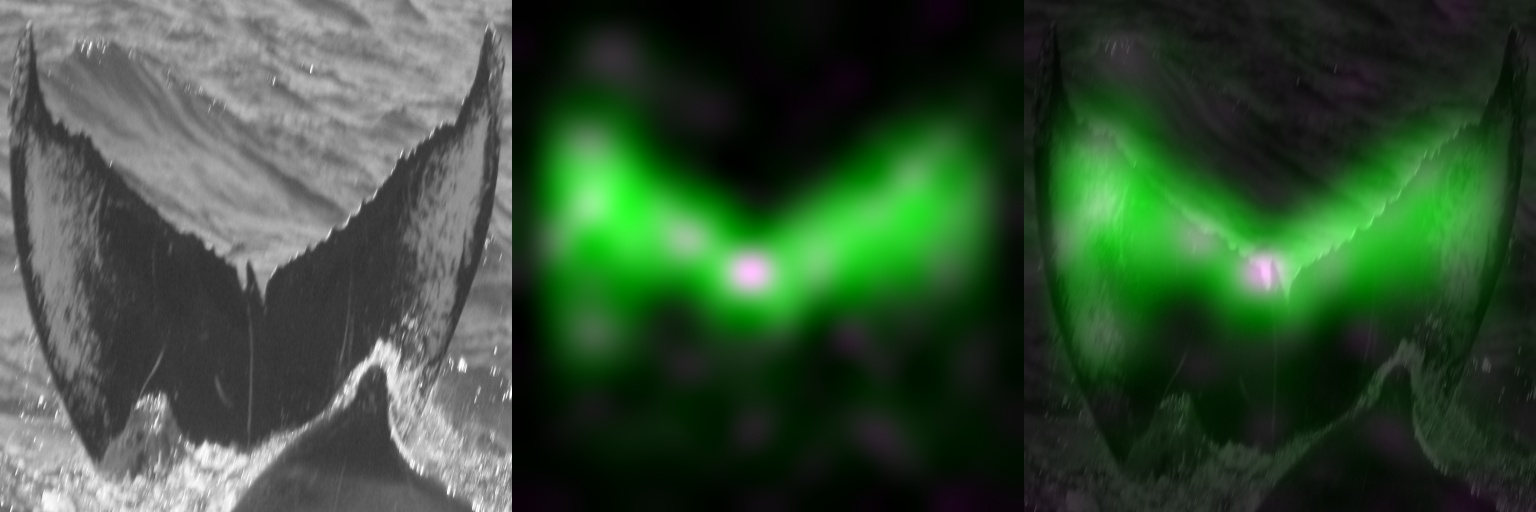

Heatmap for image: 006183fb4.jpg


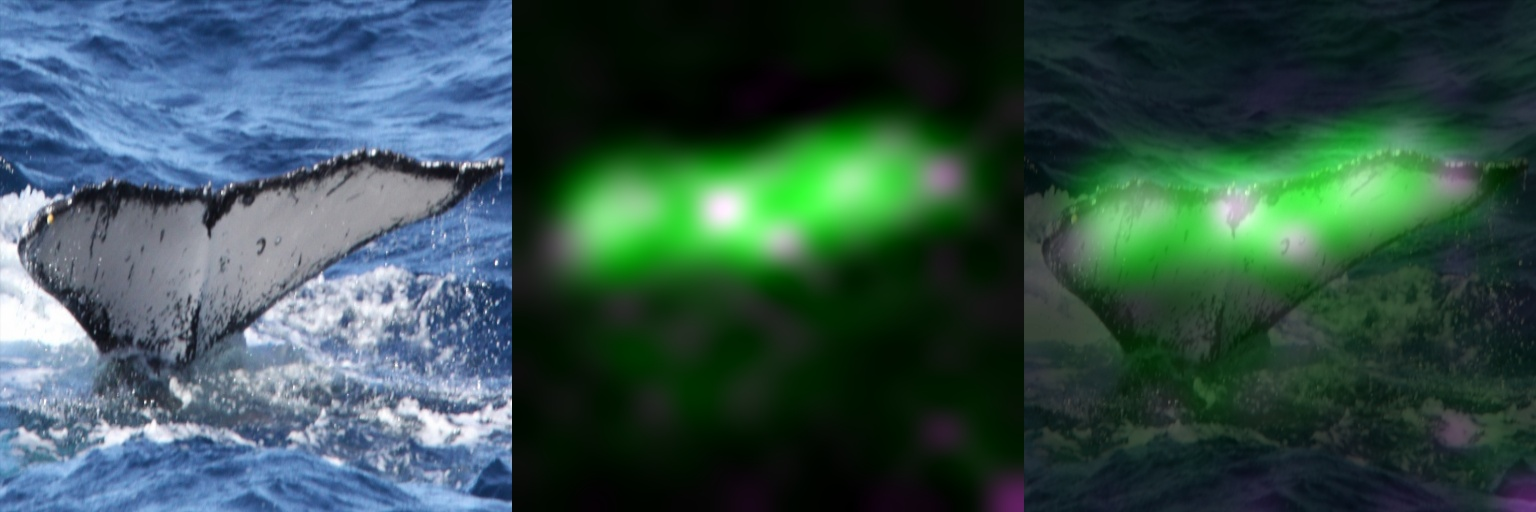

Heatmap for image: 0061febfc.jpg


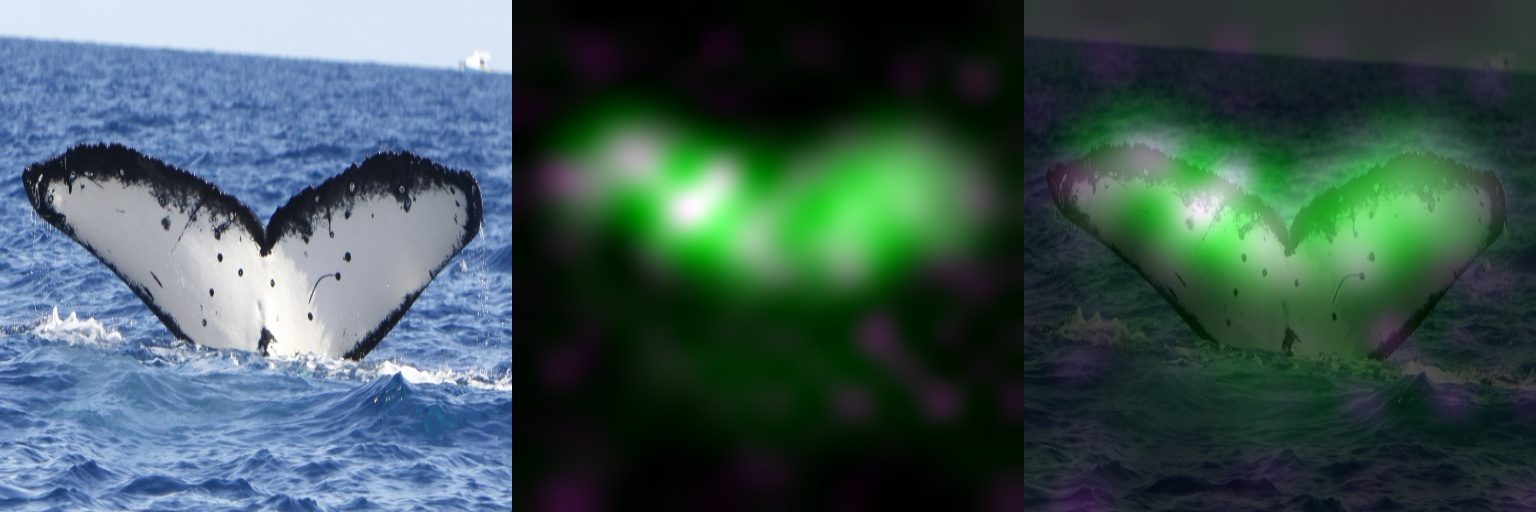

Heatmap for image: 0065d4964.jpg


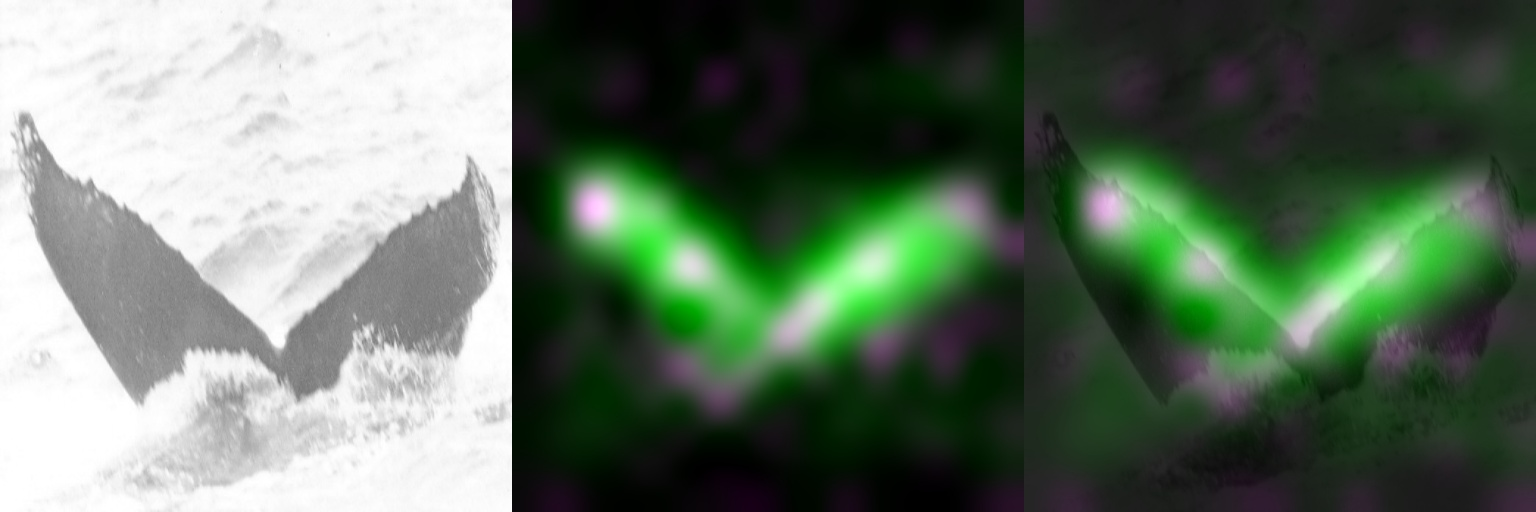

Heatmap for image: 00744bd58.jpg


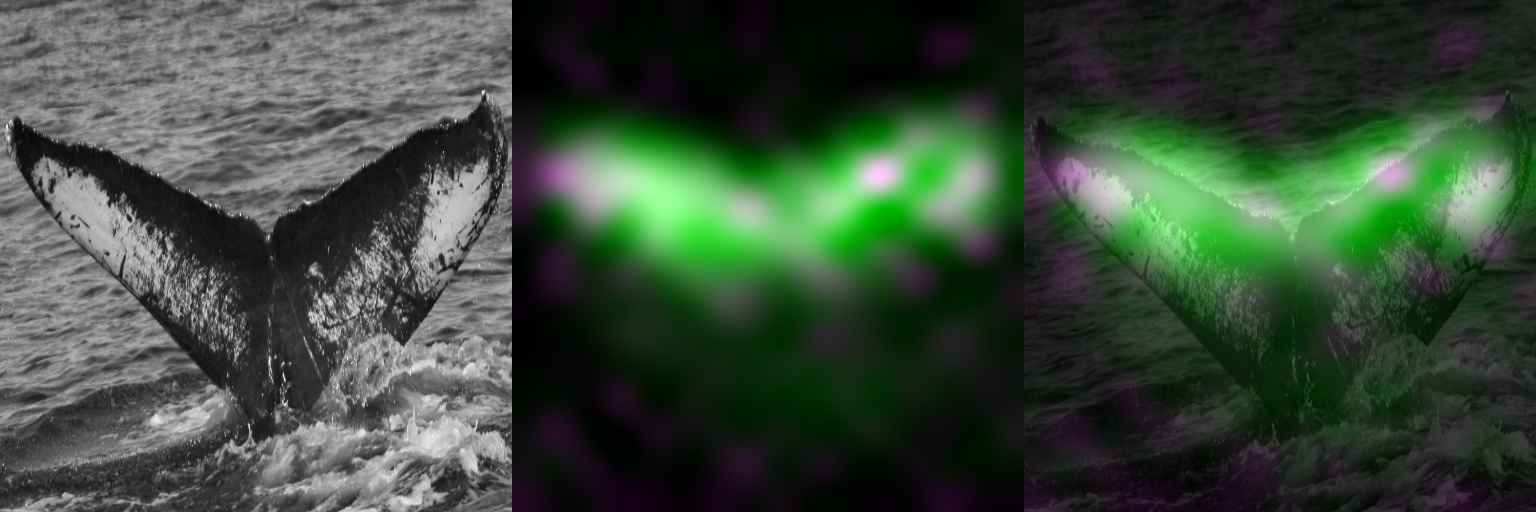

Heatmap for image: 007886aef.jpg


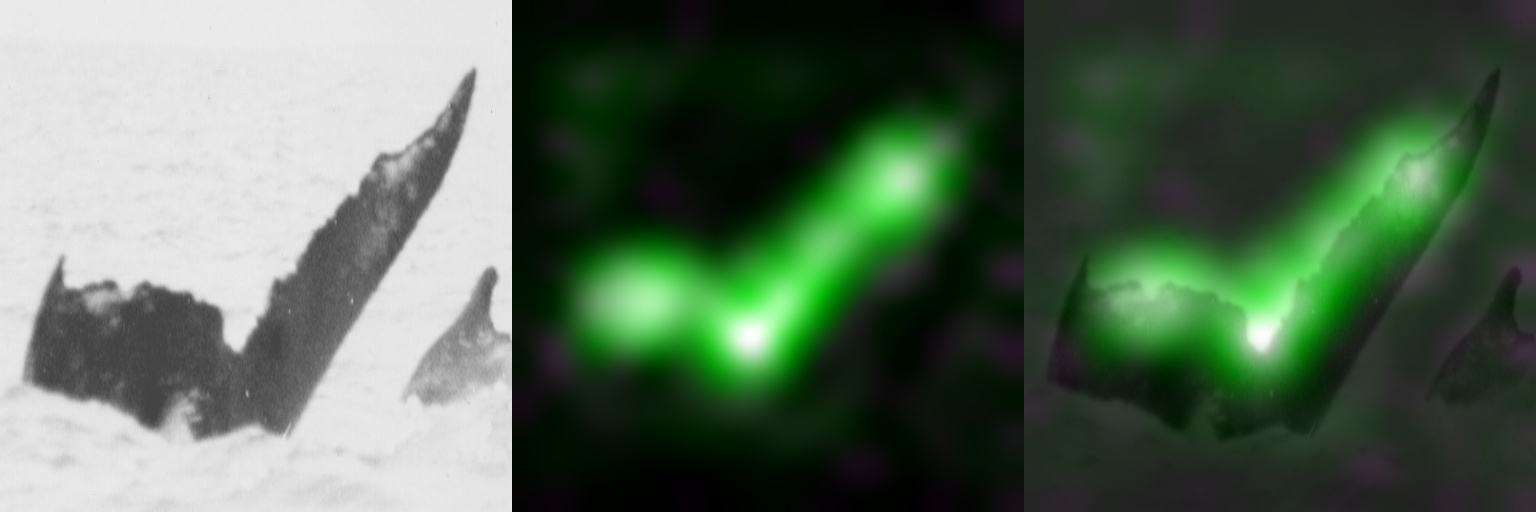

Heatmap for image: 008a4bc86.jpg


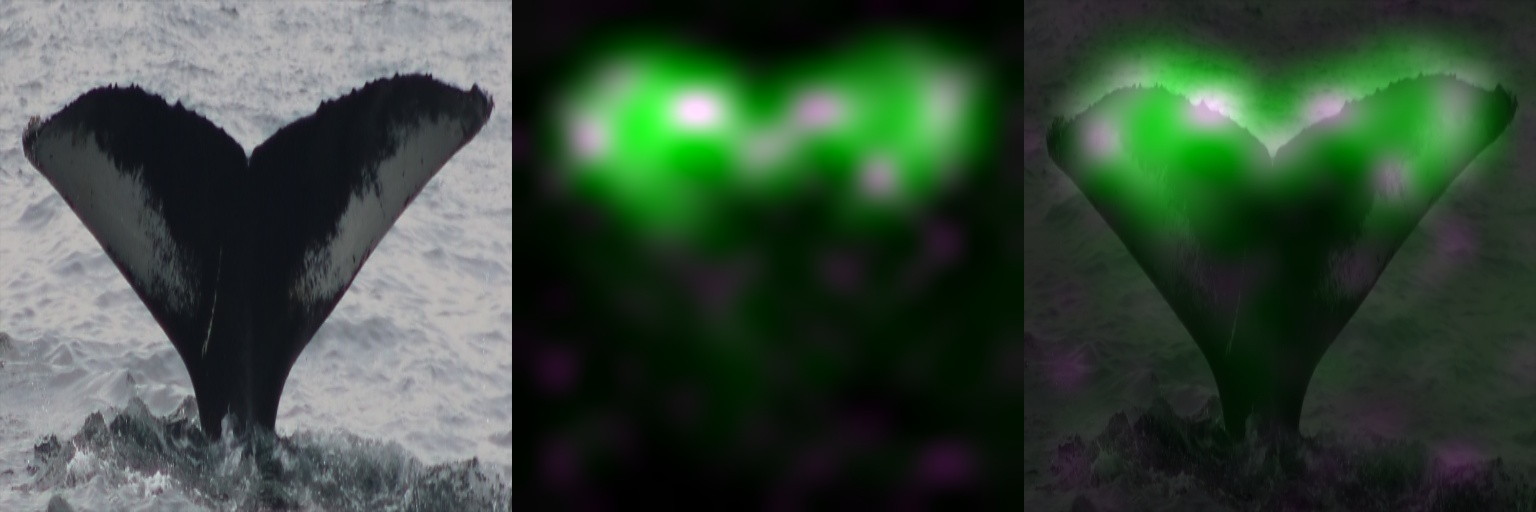

Heatmap for image: 009dd6c96.jpg


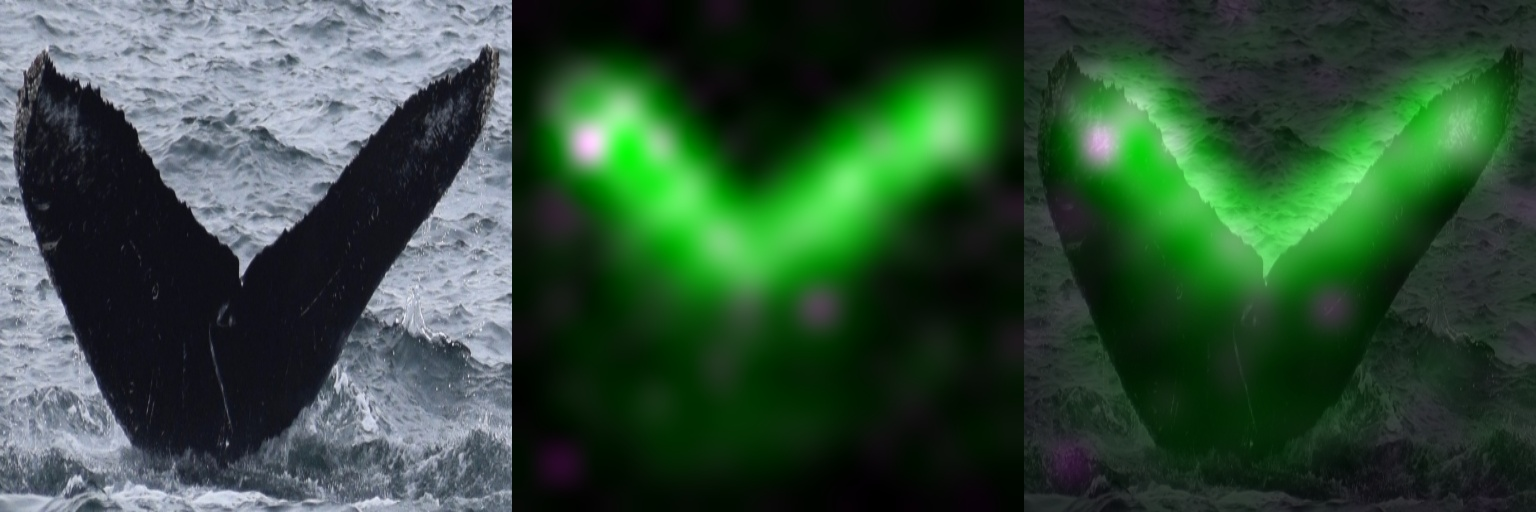

Heatmap for image: 00a427ac6.jpg


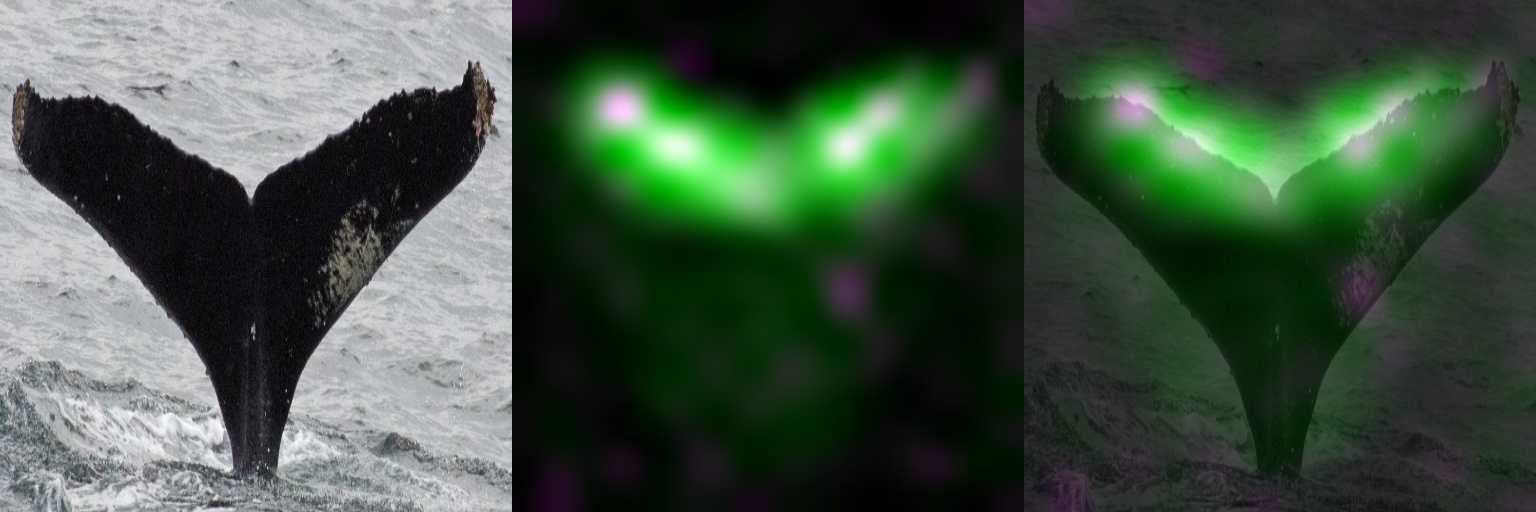

Heatmap for image: 00ac0fca6.jpg


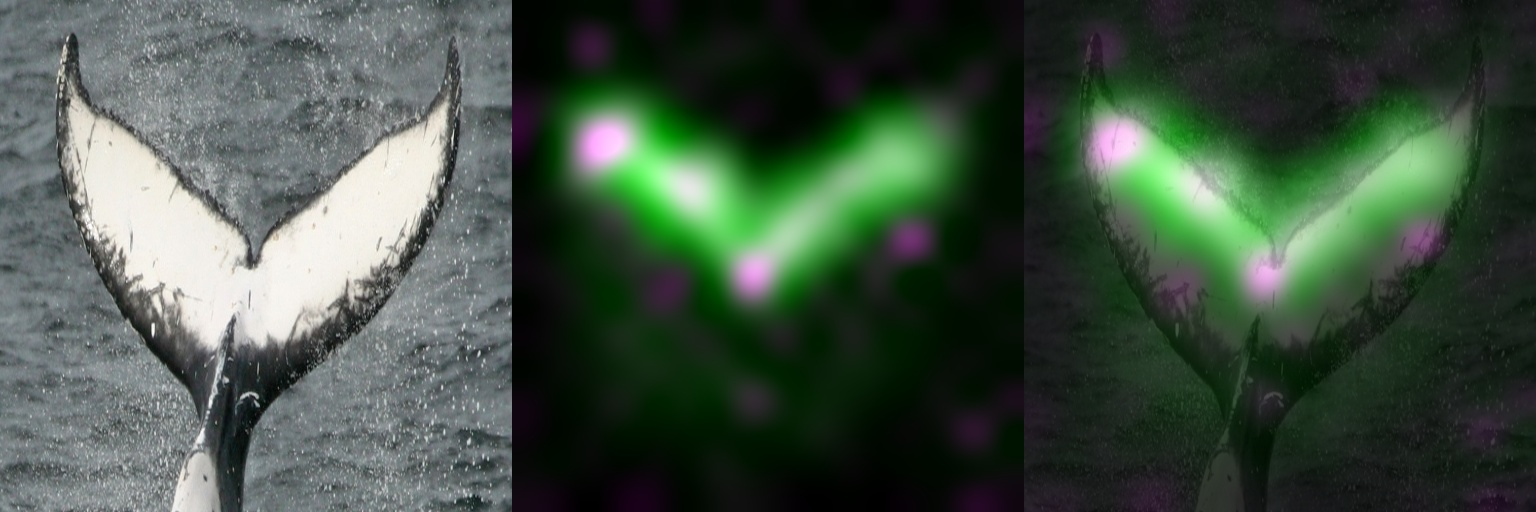

Heatmap for image: 00bb36bcf.jpg


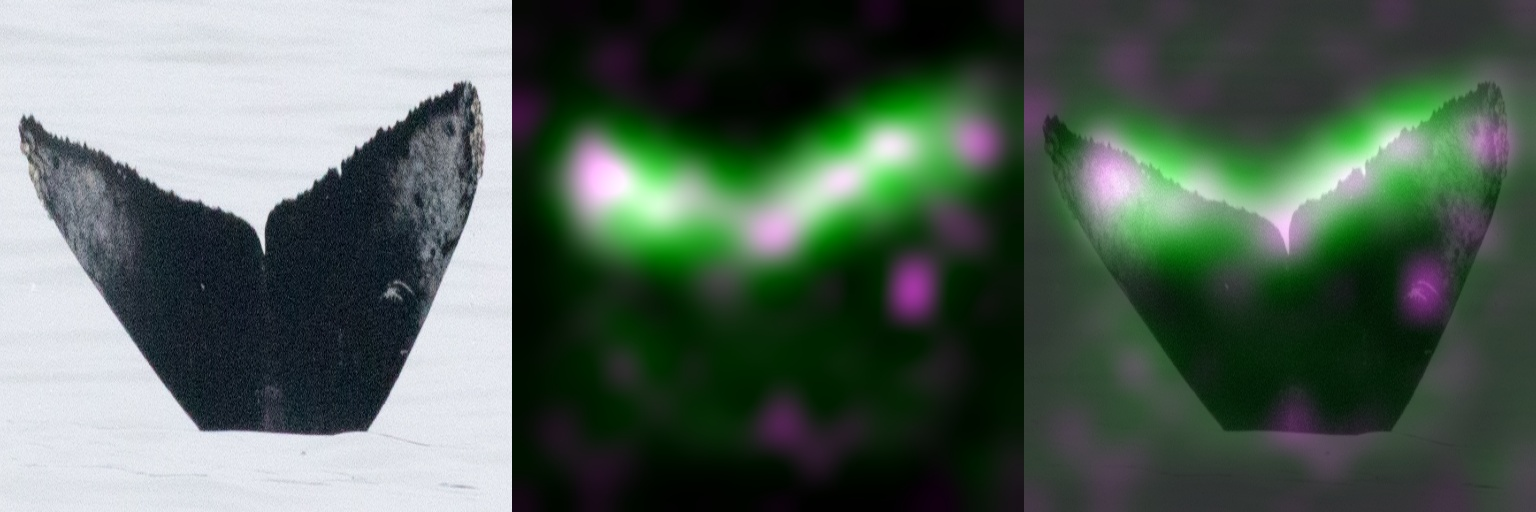

Heatmap for image: 00ca82e74.jpg


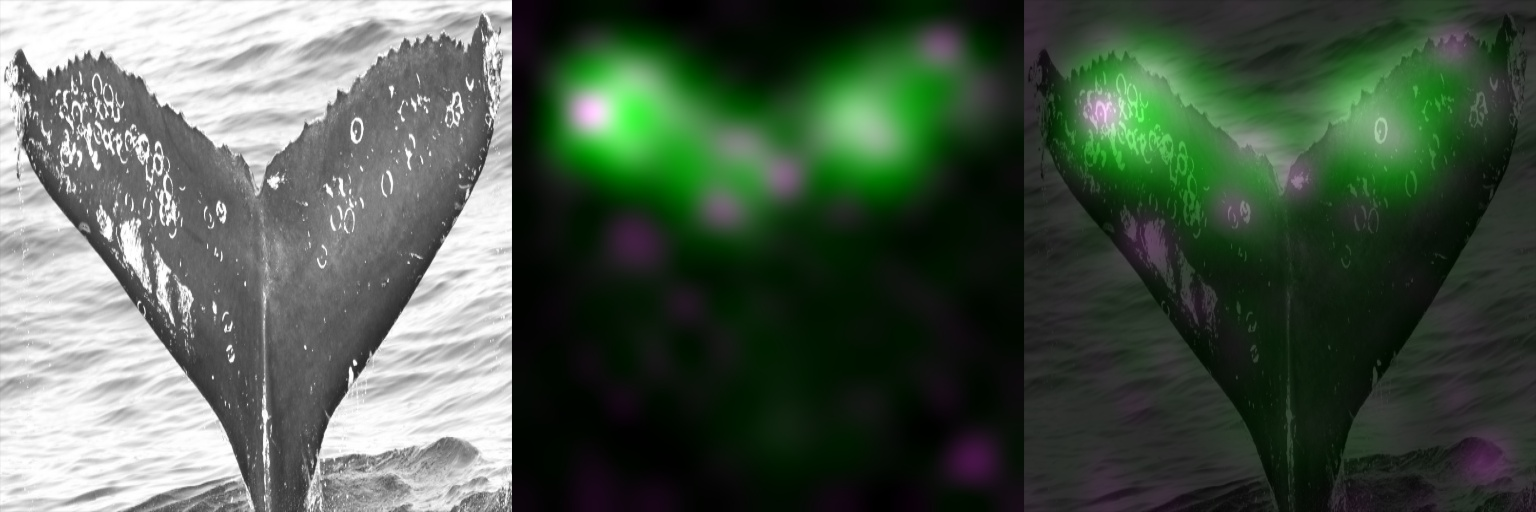

Heatmap for image: 00ccb53ec.jpg


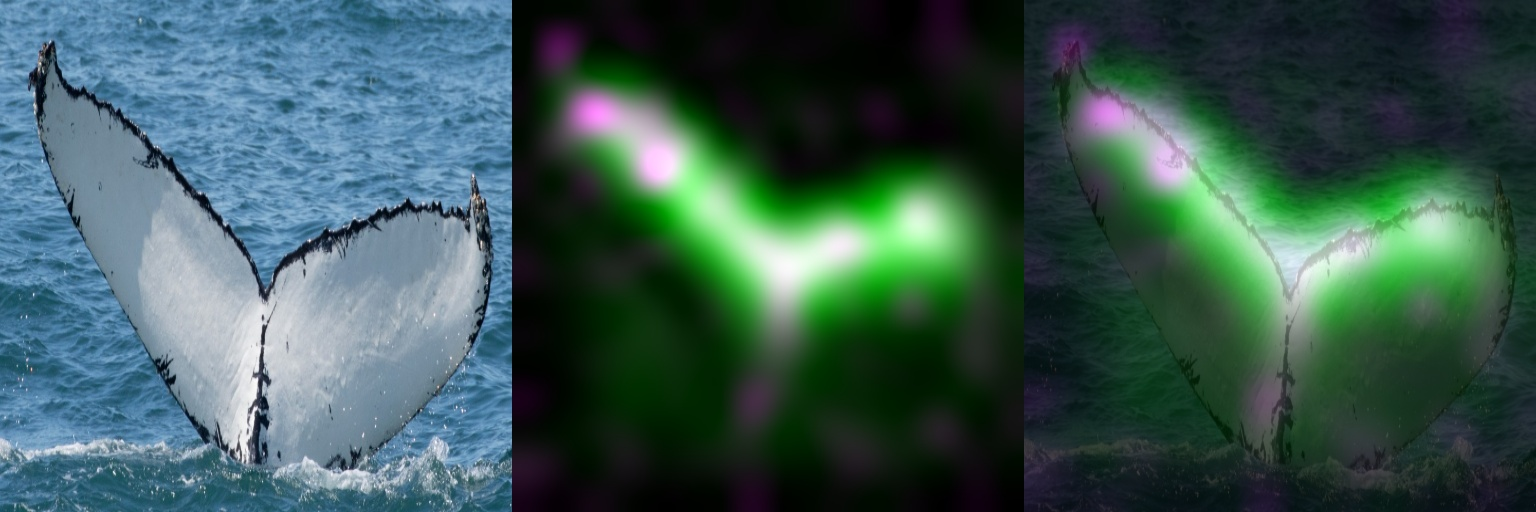

Heatmap for image: 00d101f4b.jpg


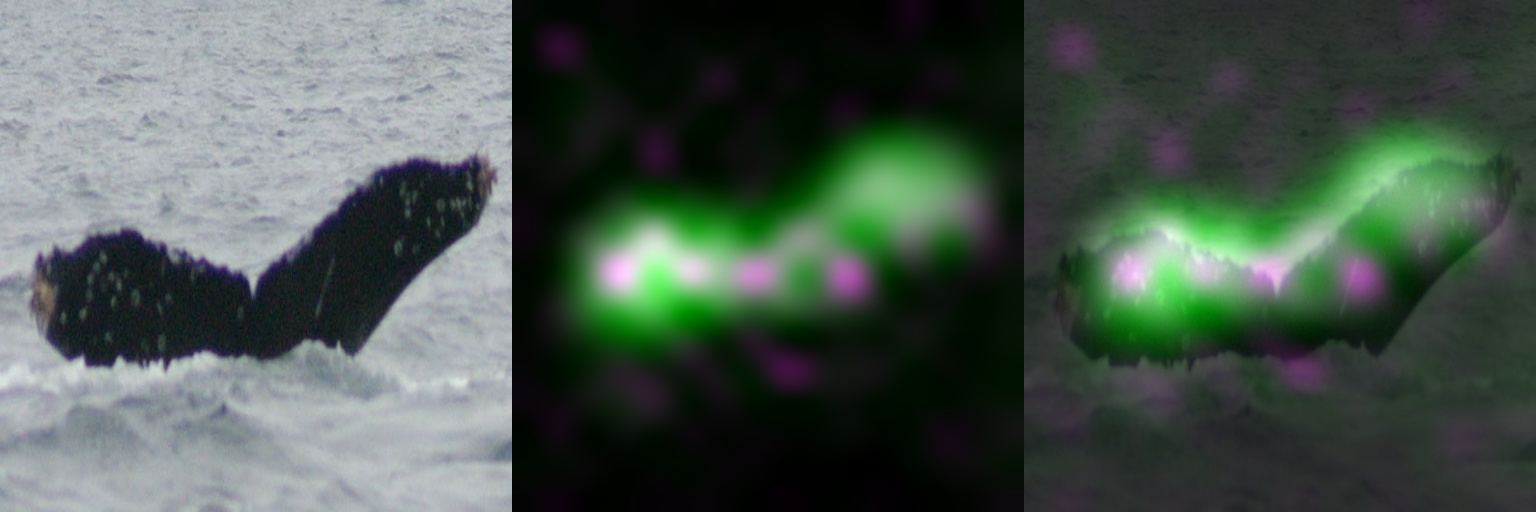

Heatmap for image: 00dc02f06.jpg


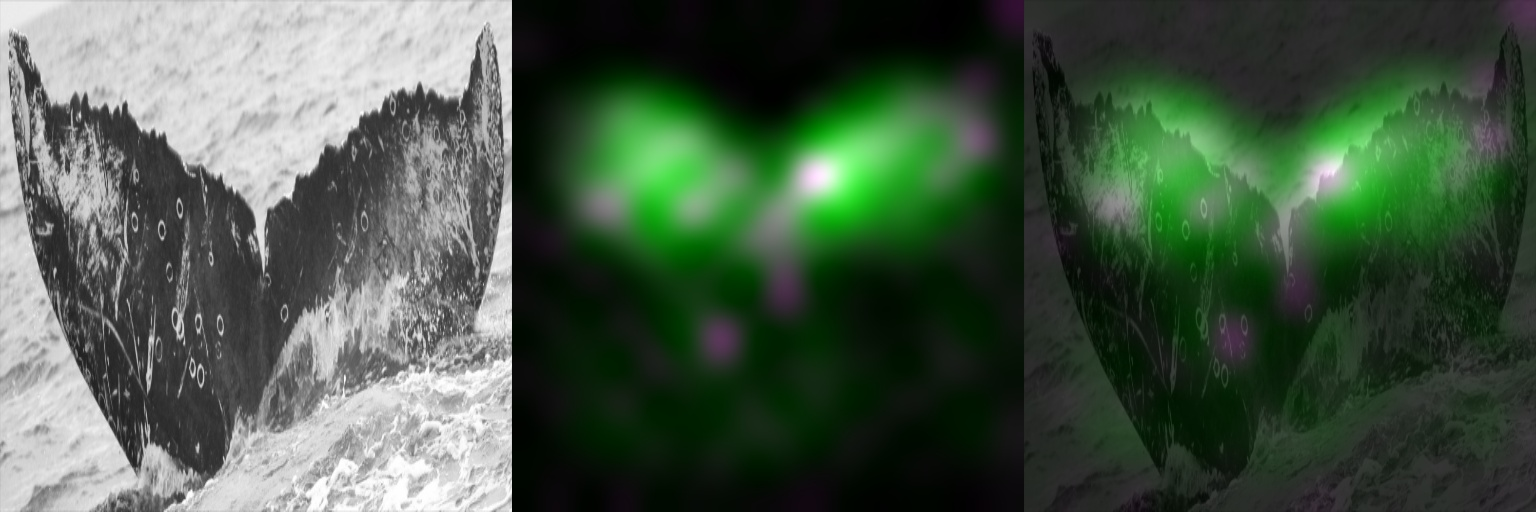

Heatmap for image: 00e94fd56.jpg


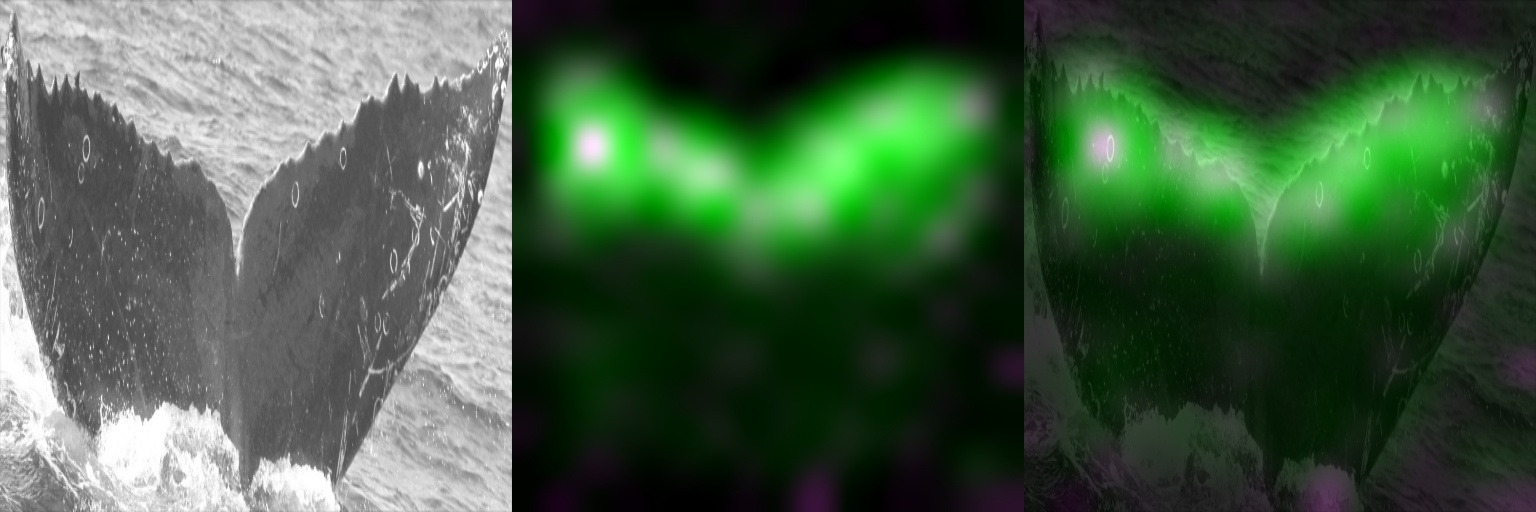

Heatmap for image: 00edab267.jpg


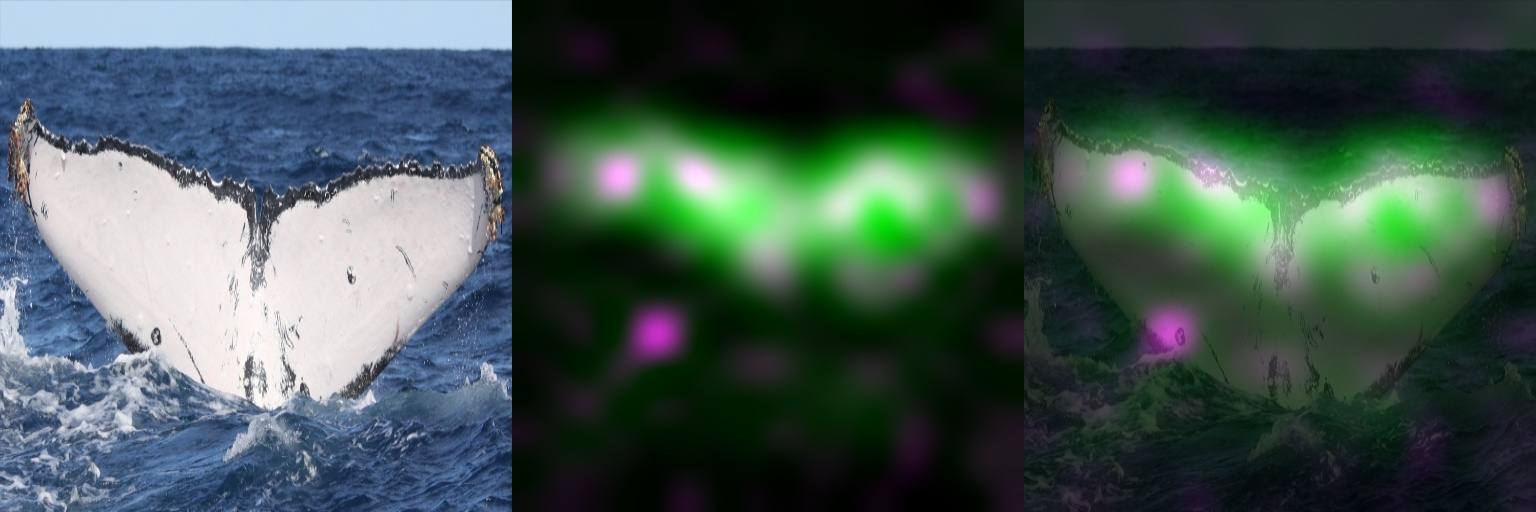

Heatmap for image: 00f44f4e1.jpg


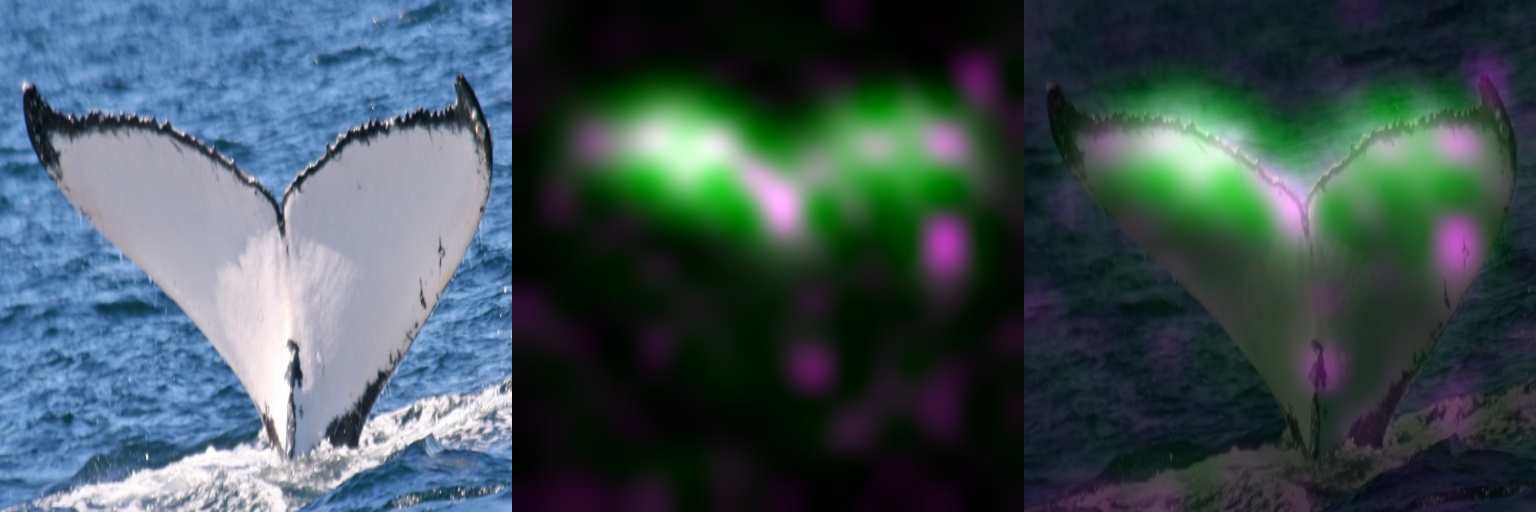

Heatmap for image: 00ff45291.jpg


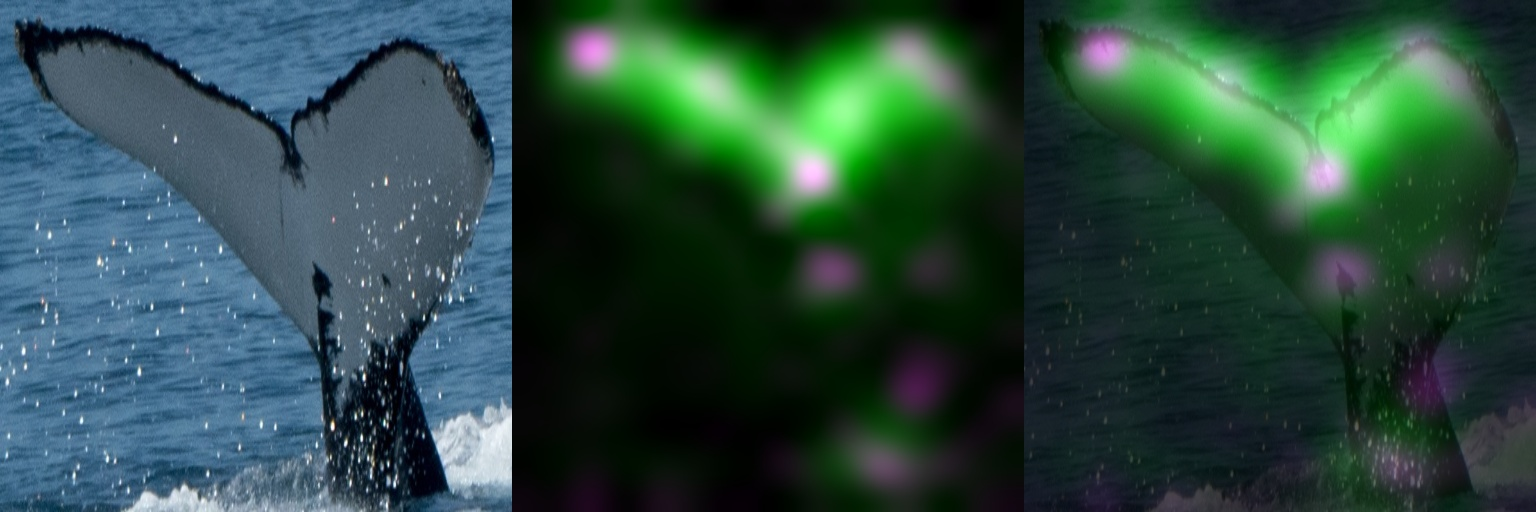

Heatmap for image: 01034a160.jpg


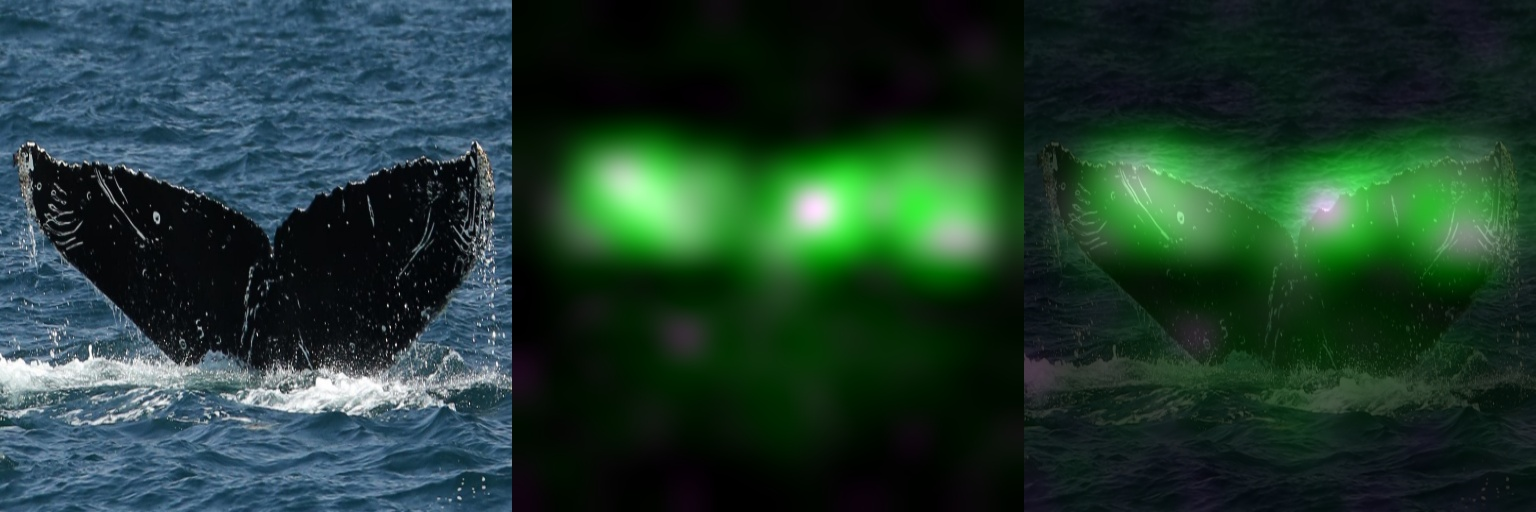

Heatmap for image: 0110a64a9.jpg


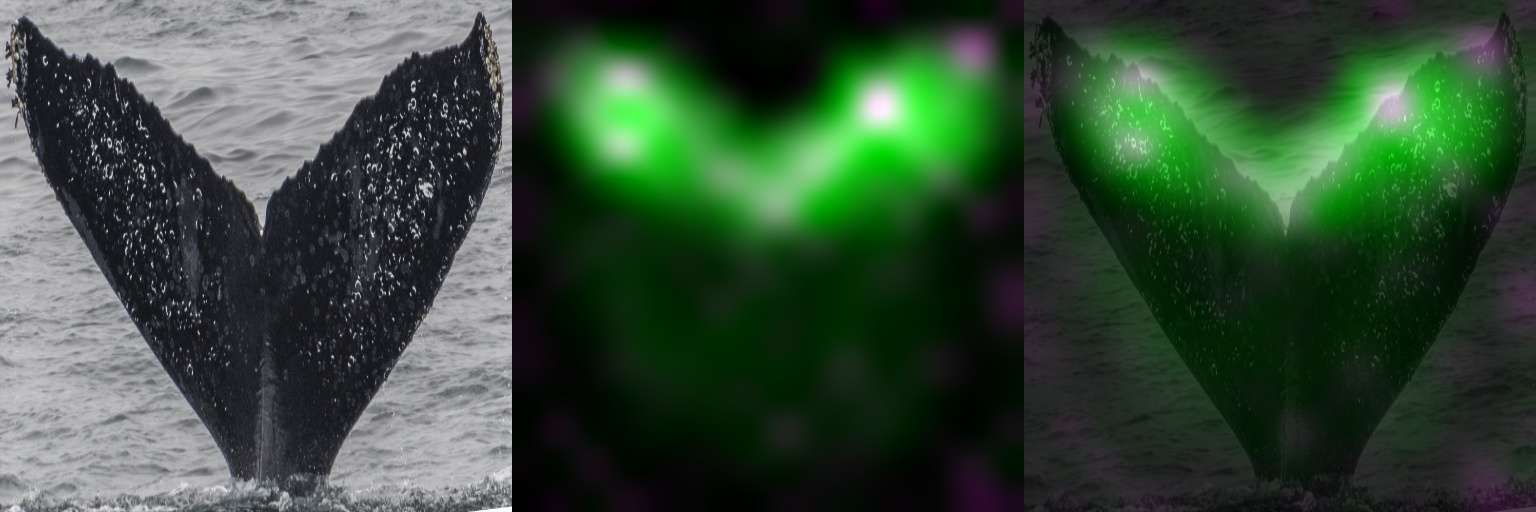

Heatmap for image: 011490ea7.jpg


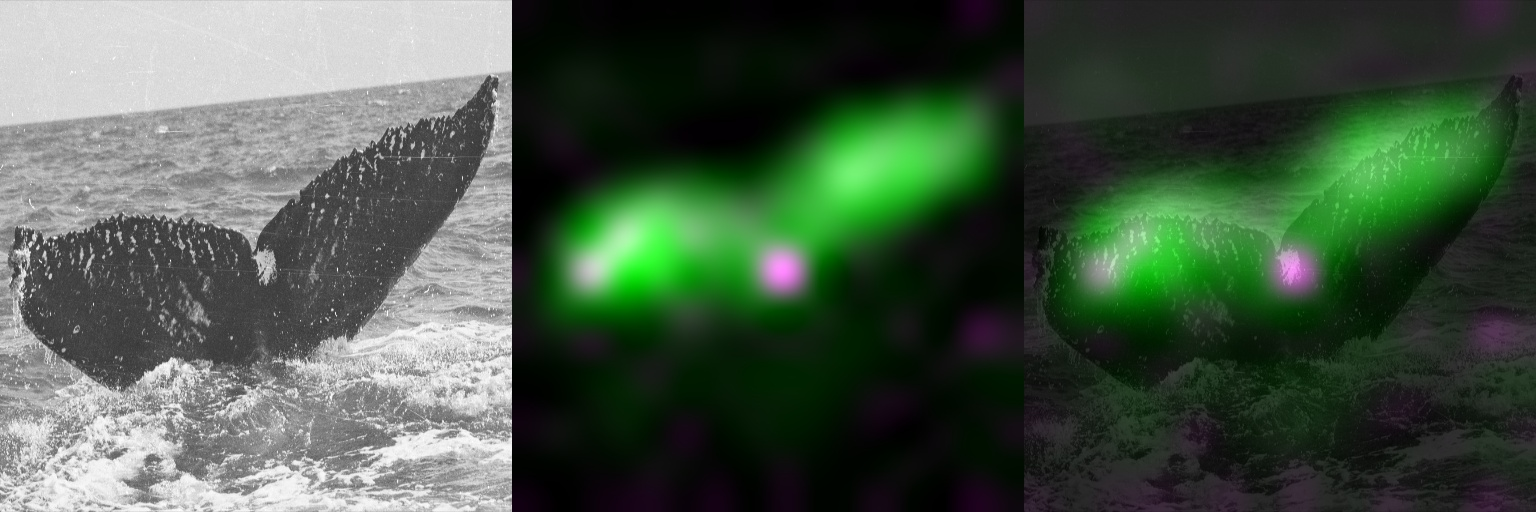

Heatmap for image: 01288355d.jpg


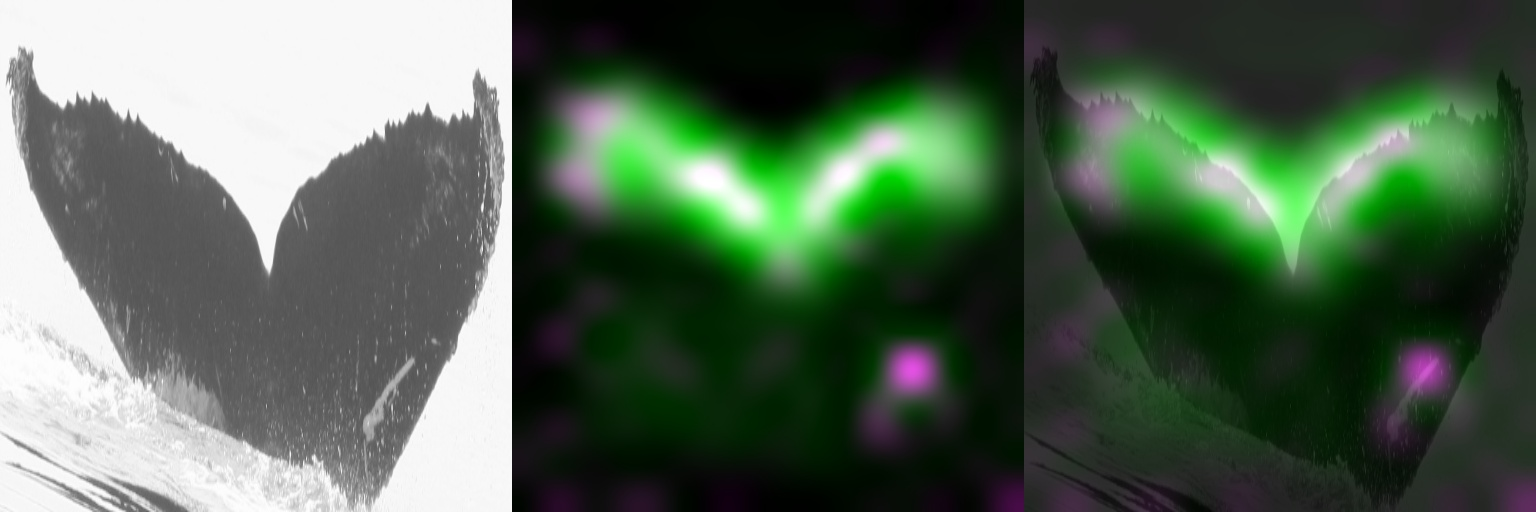

Heatmap for image: 012dbdb59.jpg


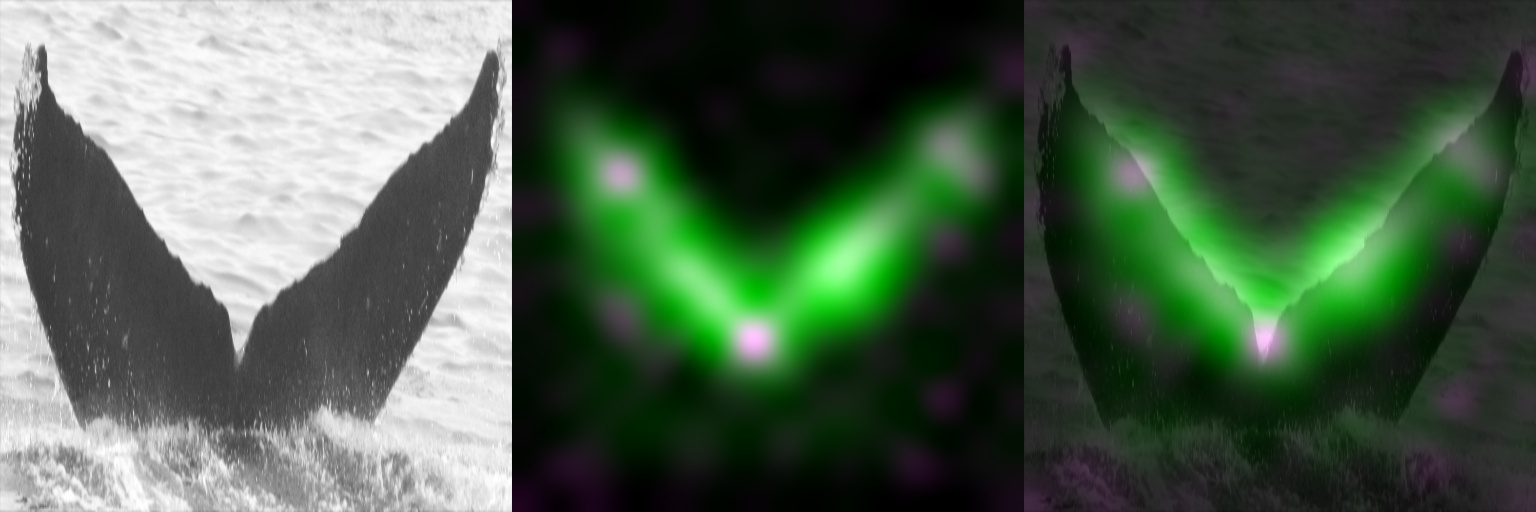

Heatmap for image: 0133056d1.jpg


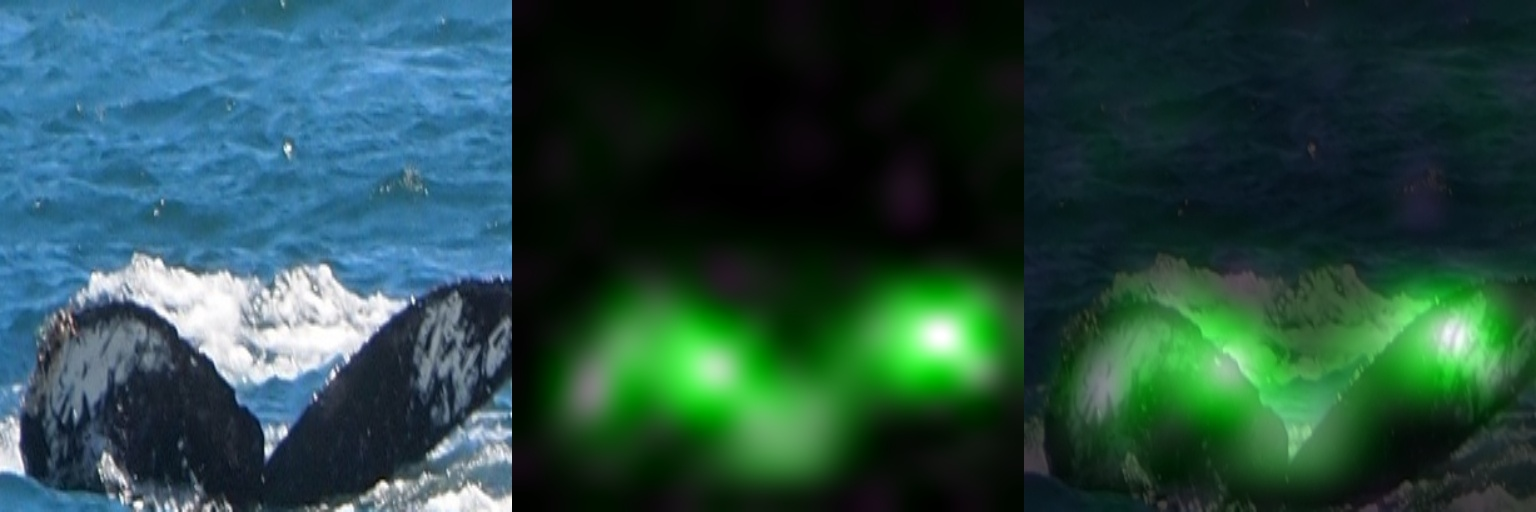

Heatmap for image: 013cb8d04.jpg


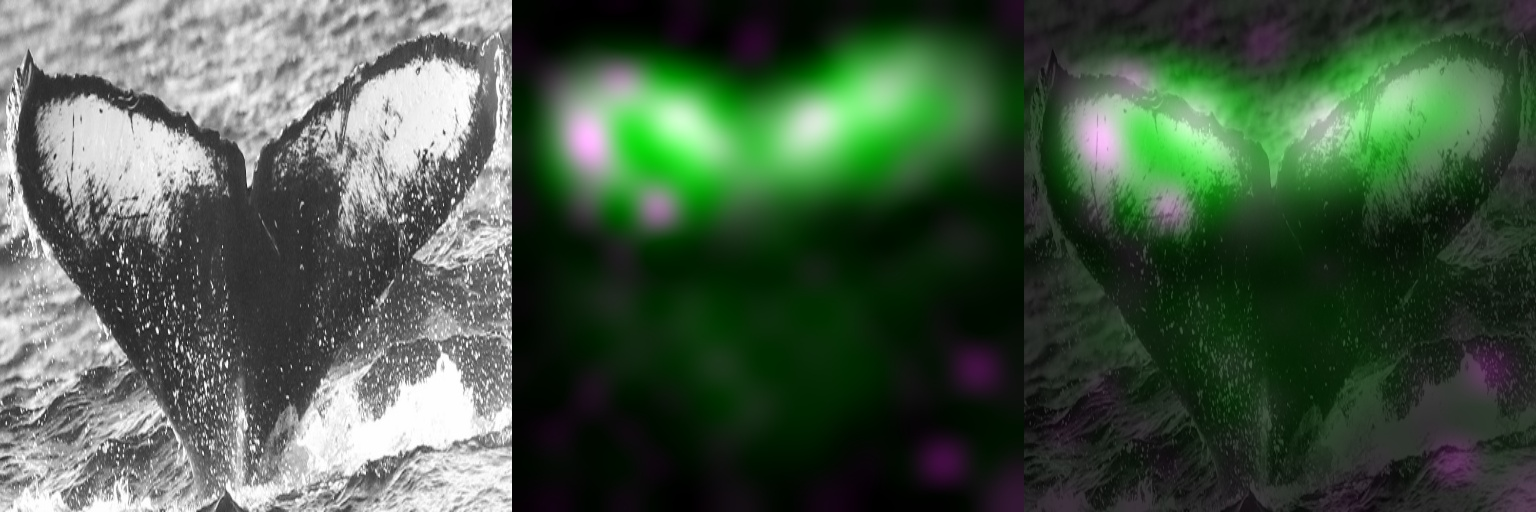

Heatmap for image: 013e23c3f.jpg


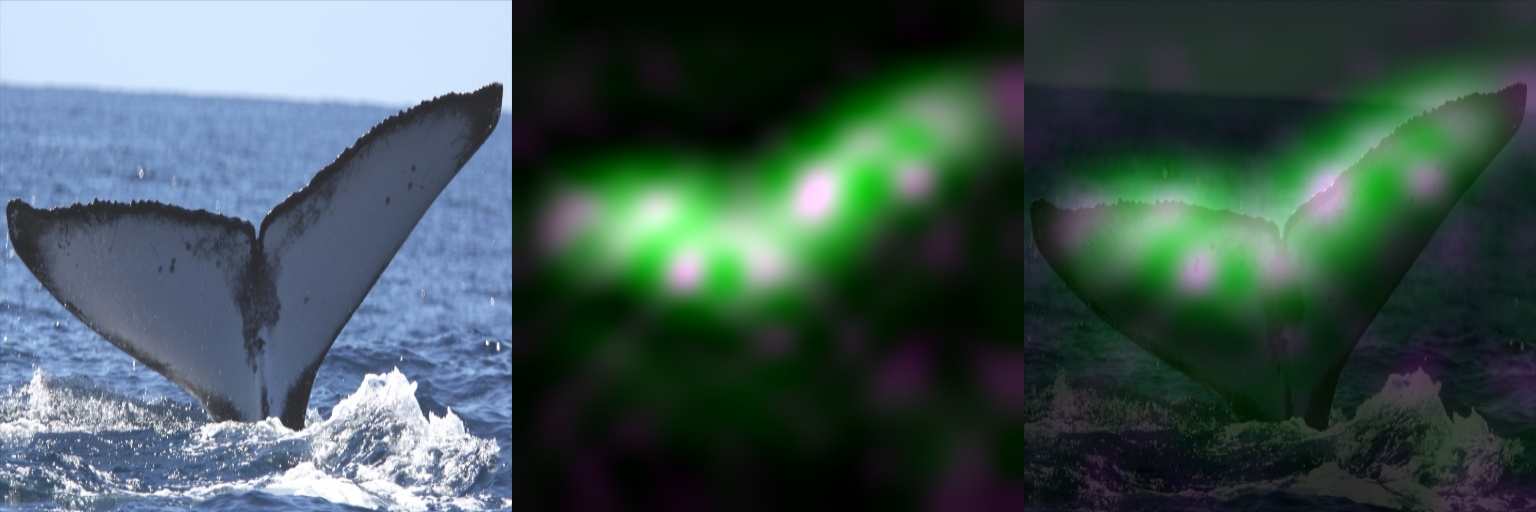

Heatmap for image: 01665bc26.jpg


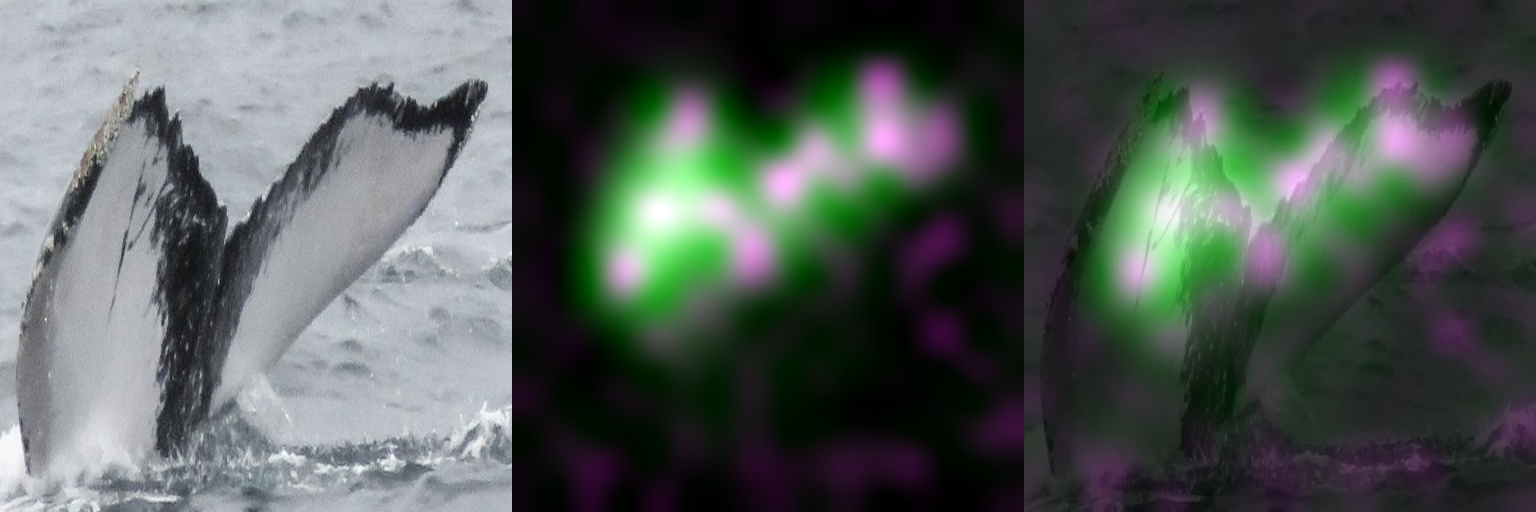

Heatmap for image: 0169cec0e.jpg


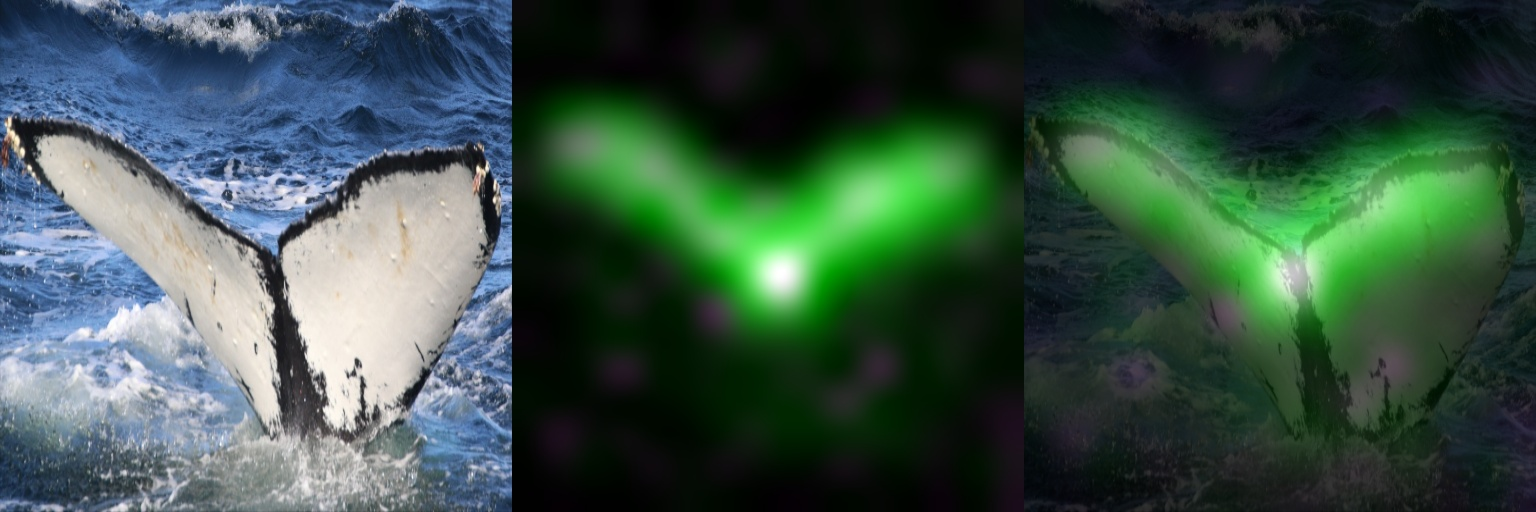

Heatmap for image: 016bbca6e.jpg


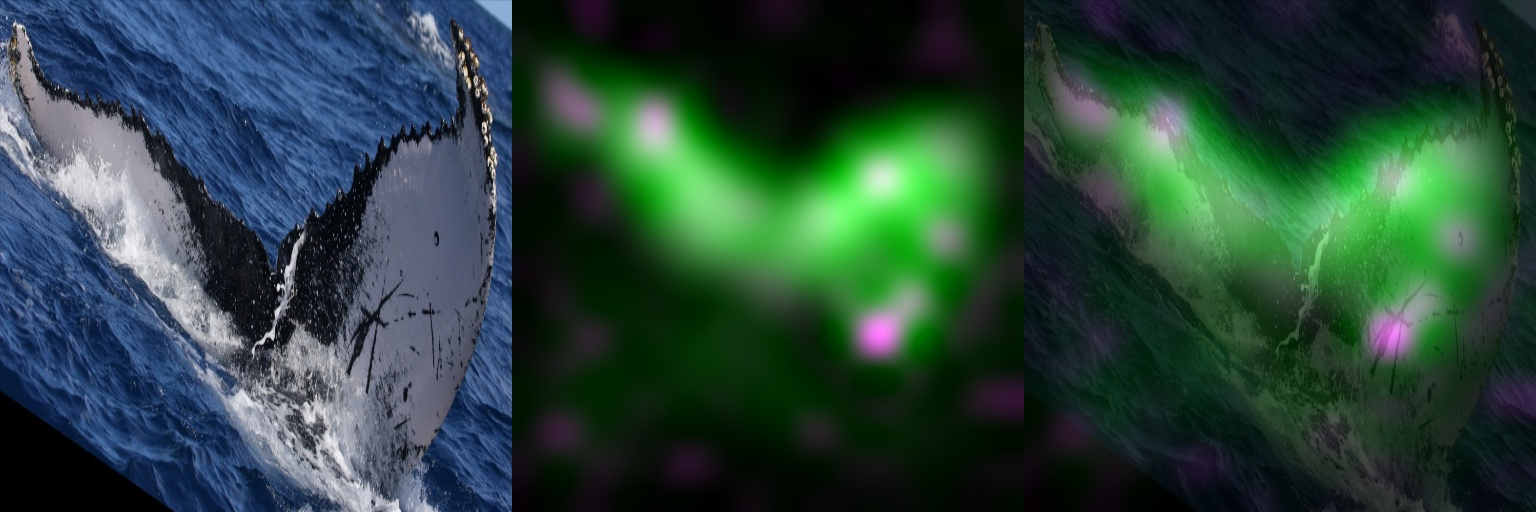

Heatmap for image: 016ca6f9c.jpg


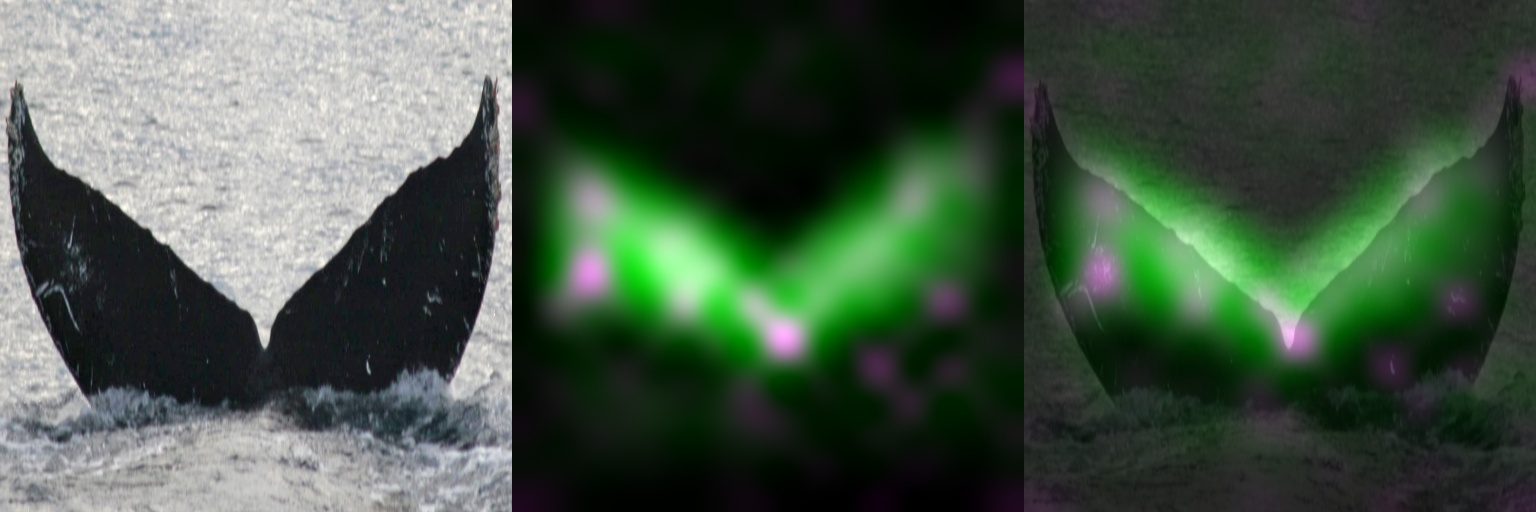

Heatmap for image: 0170f741c.jpg


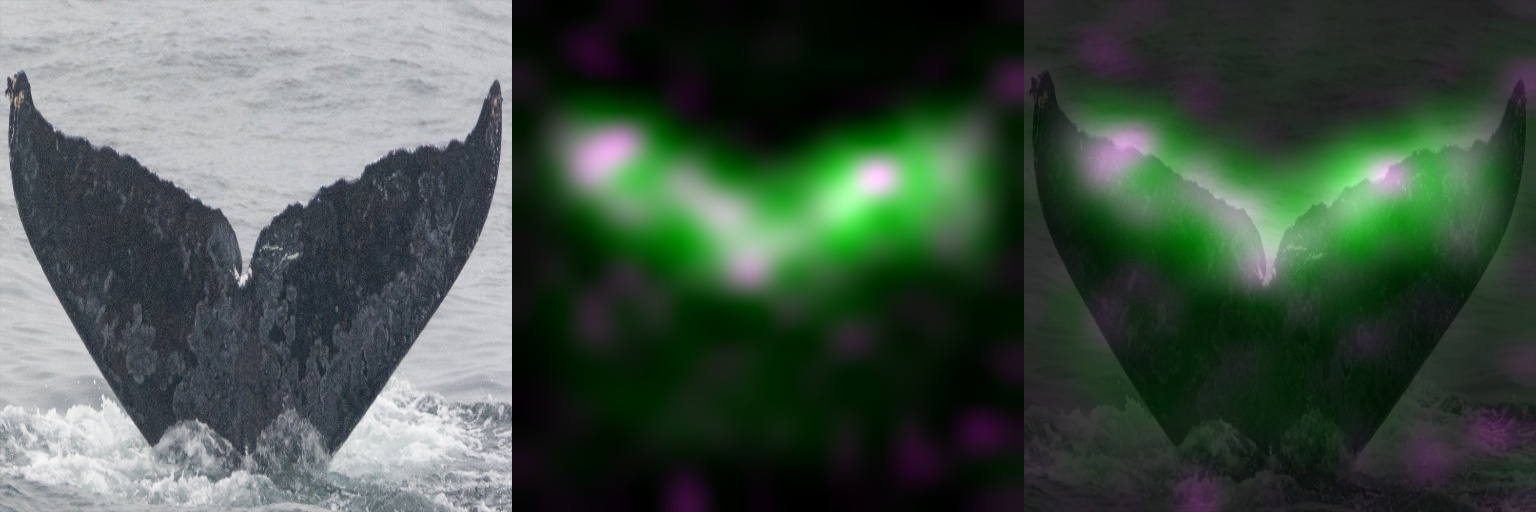

Heatmap for image: 0182ae396.jpg


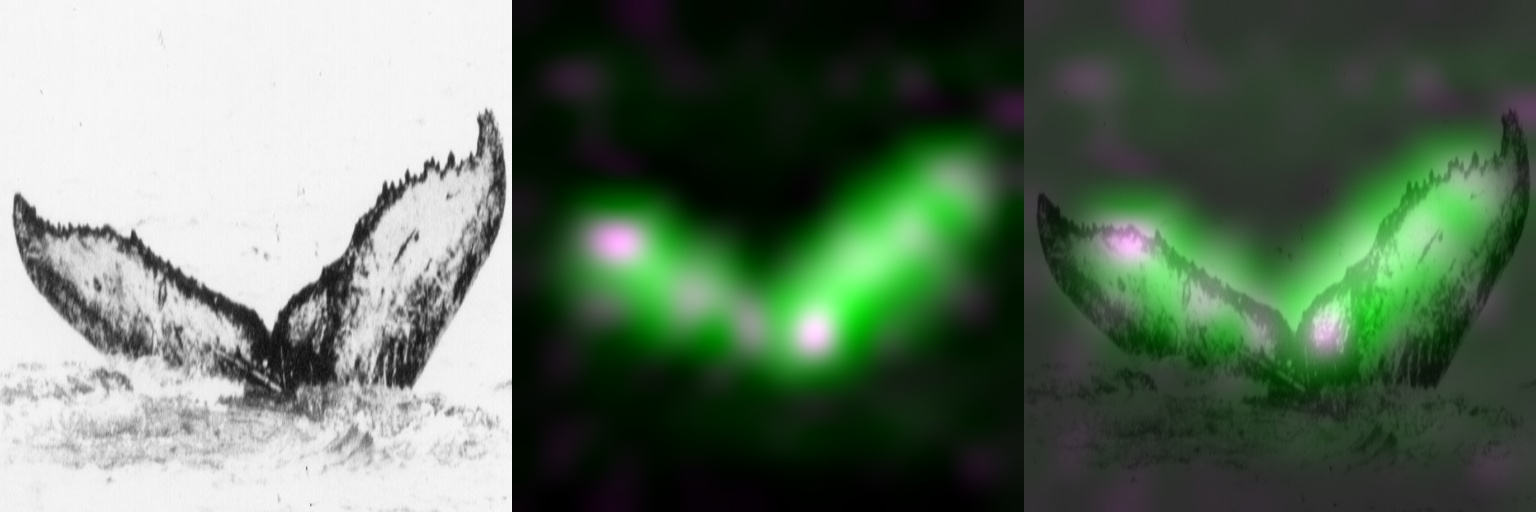

Heatmap for image: 01830c9cf.jpg


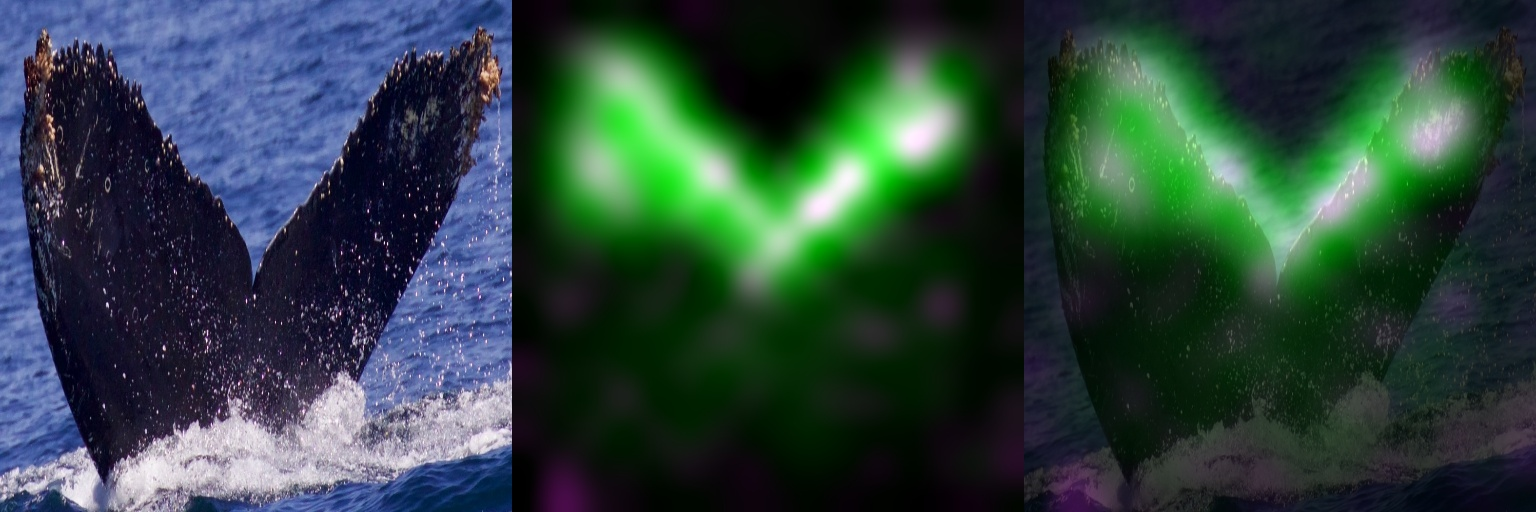

In [5]:
create_activation_maps()